**Muhamad Dio Riza Pratama**

**Universitas Buana Perjuangan**

**Dicoding Indonesia - Kampus Merdeka**

# Import Library

In [ ]:
pip install emoji


     |████████████████████████████████| 170 kB 29.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=0ea2e4954bed500f30c6b551d0889c3f7065597ded994722ad94f0f1bdef6c64
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
pip install jcopml

     |████████████████████████████████| 100 kB 8.8 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.14-py2.py3-none-any.whl size=33655 sha256=55d15a9589e8c22d6474989ccf4142bff52183aa93453e16caab6e2352a00d4a
  Stored in directory: /root/.cache/pip/wheels/d9/6a/86/9a622c06f65732afe0e31c02a92fae6ab663ffd7162bcf5125
Successfully built jcopml


In [ ]:
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
import re

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from jcopml.plot import plot_missing_value
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import emoji  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Get Dataset

Dataset dipilih melalui platform kaggle, Kaggle adalah komunitas online yang dibangun oleh Goldbloom di tahun 2010. Komunitas ini mengumpulkan para ahli ataupun minat dalam dunia data science yang ingin belajar lebih dalam terkait machine learning ataupun ilmu terkait lainnya. Kaggle telah memiliki lebih dari 1000 dataset, 170.000 post di forum, dan 300 kernel. Oleh karena itu, Kaggle dianggap sebagai platform yang luar biasa hingga diakuisisi Google pada tahun 2017. Kaggle juga platform yang menyediakan open source dataset dan notebook data sains. Berisi komunitas dari penggiat data dari seluruh dunia yang mana berisi aktivitas sharing data, kompetisi data dan pembelajaran data di platform ini.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammaddioriza","key":"9659fcadd4165a4b3a9c1a4820340a31"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!pip install -q kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d subhajournal/drug-recommendations

 91% 9.00M/9.88M [00:00<00:00, 37.1MB/s]
100% 9.88M/9.88M [00:00<00:00, 33.0MB/s]


In [ ]:
local_zip = '/content/drug-recommendations.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Import Dataset 

Dataset diambil dari Kaggle yang mana berisi data dari Drugs Recomendation yang merupakan data berisi banyak jenis obat, gejala dan ulasan pengguna tentu saja dataset ini sangat berguna untuk rekomendasi obat berdasarkan jenis penyakitnya dan ulasan. Ulasan pengguna akan menjadi faktor yang membantu dalam mengidentifikasi sentimen pengguna berguna untuk meresepkan obat yang sangat cocok untuk penyakit dan gangguan kesehatan tertentu.

Dataset terdiri dari beberapa variabel drugName, Prescribed_for, Drug_Review, User_Rating, Date dan Count_of_Reviews. Karena akan dibuat sistem rekomendasi menggunakan content based filtering, maka ada beberapa variabel yang tidak diperlukan. 

In [ ]:
df = pd.read_csv('/tmp/Drug_Data.csv')
df = df.drop(columns=['User_Rating', 'Count_of_Reviews', 'Date'])
df.head()

,drugName,Prescribed_for,Drug_Review
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th..."
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ..."
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms"""
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al..."
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc..."


# Data Preparation & EDA

Proses awal pada data preparation disini adalah dengan menggabungkan dua variabel yaitu prescribed_for dan Drug_Review. Tujuannya adalah untuk membuat metadata yang membuat model dapat bekerja lebih baik lagi, karena pada dasarnya model yang akan kita buat content based filtering adalah rekomendasi berdasarkan kemiripan. Percobaan pertama telah dibuat dengan hanya menjadikan Drug_review sebagai data yang diencoding tetapi hasilnya kurang memuaskan. Oleh sebab itu disini kita menggabungkan kedua variabel tersebut dan memanfaatkannya untuk memperkembangkan model menjadi variabel baru bernama metadata.

In [ ]:
df['metadata'] = df['Prescribed_for'].str.cat(df['Drug_Review'],sep=" ")
df['metadata'] = df['metadata'].apply(str)
df = df.drop(columns=['Drug_Review'])
df.head(10)

,drugName,Prescribed_for,metadata
0,Mirtazapine,Depression,"Depression ""I&#039;ve tried a few antidepressa..."
1,Mesalamine,"Crohn's Disease, Maintenance","Crohn's Disease, Maintenance ""My son has Crohn..."
2,Bactrim,Urinary Tract Infection,"Urinary Tract Infection ""Quick reduction of sy..."
3,Contrave,Weight Loss,"Weight Loss ""Contrave combines drugs that were..."
4,Cyclafem 1 / 35,Birth Control,"Birth Control ""I have been on this birth contr..."
5,Zyclara,Keratosis,"Keratosis ""4 days in on first 2 weeks. Using ..."
6,Copper,Birth Control,"Birth Control ""I&#039;ve had the copper coil f..."
7,Amitriptyline,Migraine Prevention,"Migraine Prevention ""This has been great for m..."
8,Methadone,Opiate Withdrawal,"Opiate Withdrawal ""Ive been on Methadone for o..."
9,Levora,Birth Control,"Birth Control ""I was on this pill for almost t..."


Selanjutnya adalah pengecekan jumlah baris yang ada pada dataset dicek dengan menggunakan df.shape dan outputnya adalah (53766, 3)


In [ ]:
df.shape

(53766, 3)

Tentu banyaknya data ini belum tentu bersih, oleh sebab itu dilakukan pengecekan data yang hilang atau value missing. disini ada dua cara yaitu dengan melihatnya melalui plot dengan bantuan library jcopml ``plot_missing_value(df)`` atau bisa dengan menggunakan bantuan dari library pandas yaitu dengan ``df.isnull().sum().sum())`` dan ternyata data kita ada yang kosong atau nan berjumlah 295 data.

Solusi untuk mengatasi permasalahan ini adalah dengan menghilangkan data yang kita anggap kotor dengan bantuan pandas maka kode untuk menghilangkan data tersebut adalah:


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drugName        53766 non-null  object
 1   Prescribed_for  53471 non-null  object
 2   metadata        53766 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


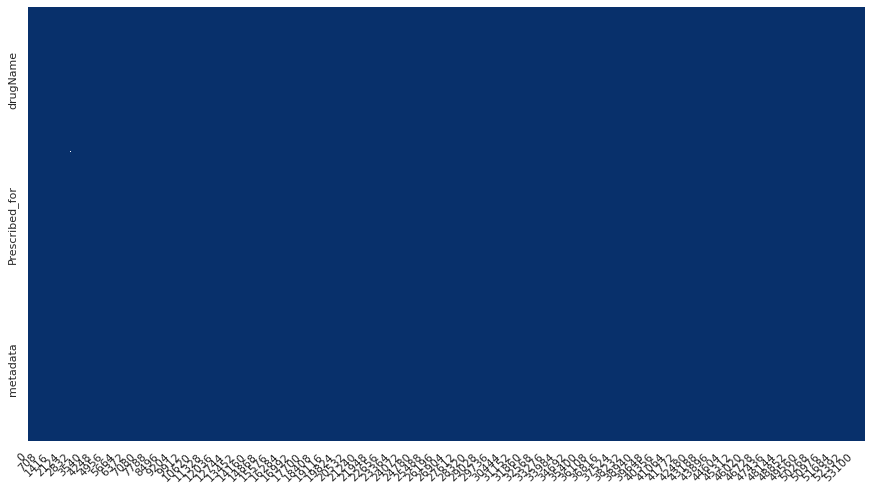

In [ ]:
plot_missing_value(df)

In [ ]:
print("Data NaN berjumlah :",df.isnull().sum().sum())

Data NaN berjumlah : 295


In [ ]:
df = df.dropna() 
print("Data NaN menjadi : ", df.isnull().sum().sum())
df.shape

Data NaN menjadi :  0


(53471, 3)

In [ ]:
df

,drugName,Prescribed_for,metadata
0,Mirtazapine,Depression,"Depression ""I&#039;ve tried a few antidepressa..."
1,Mesalamine,"Crohn's Disease, Maintenance","Crohn's Disease, Maintenance ""My son has Crohn..."
2,Bactrim,Urinary Tract Infection,"Urinary Tract Infection ""Quick reduction of sy..."
3,Contrave,Weight Loss,"Weight Loss ""Contrave combines drugs that were..."
4,Cyclafem 1 / 35,Birth Control,"Birth Control ""I have been on this birth contr..."
...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","Breast Cancer, Prevention ""I have taken Tamoxi..."
53762,Escitalopram,Anxiety,"Anxiety ""I&#039;ve been taking Lexapro (escita..."
53763,Levonorgestrel,Birth Control,"Birth Control ""I&#039;m married, 34 years old ..."
53764,Tapentadol,Pain,"Pain ""I was prescribed Nucynta for severe neck..."


untuk melihat penyebaran data top 5 misalnya dari penjelasan mengenai gejala atau penyakit yang diderita(Prescribed_for) dapat dicheck dengan visualisasi data dengan bantuan library matplotlib dan seaborn dengan kode:

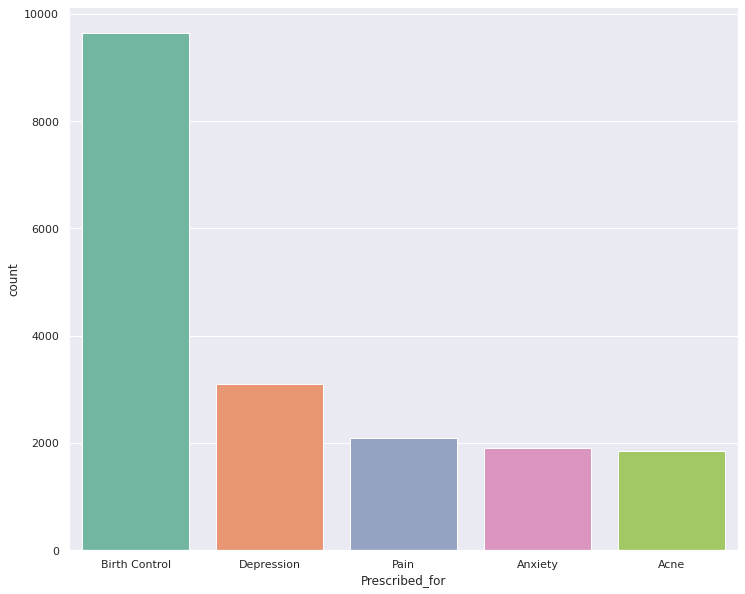

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="Prescribed_for", data=df, palette="Set2", order=df['Prescribed_for'].value_counts().index[0:5])

Terlihat disini bahwa gejala birth control mendominasi kasus yang ada pada dataset ini dengan penyebaran datanya diatas 9000 kasus. Dilanjutkan dengan Depression, pain, anxiety dan acne. Untuk melihat penyebaran yang lebih lengkap beserta value angka yang ada pada setiap gejala bisa diurutkan dengan kode seperti berikut:

In [ ]:
Prescribed_for_count=df['Prescribed_for'].value_counts().sort_values(ascending=False)
Prescribed_for_count=pd.DataFrame(Prescribed_for_count)
topPrescribed_for=Prescribed_for_count[0:11]
topPrescribed_for

,Prescribed_for
Birth Control,9648
Depression,3095
Pain,2100
Anxiety,1908
Acne,1847
Bipolar Disorde,1380
Weight Loss,1248
Insomnia,1231
Obesity,1189
ADHD,1126


Selanjutnya adalah kita analysis obat apa saja yang paling banyak digunakan oleh pengguna berdasarkan ulasan, dipilih 5 obat teratas dan dengan teknik yang sama seperti diatas dapat dilihat visualisasi dan tabel penyebaran datanya:

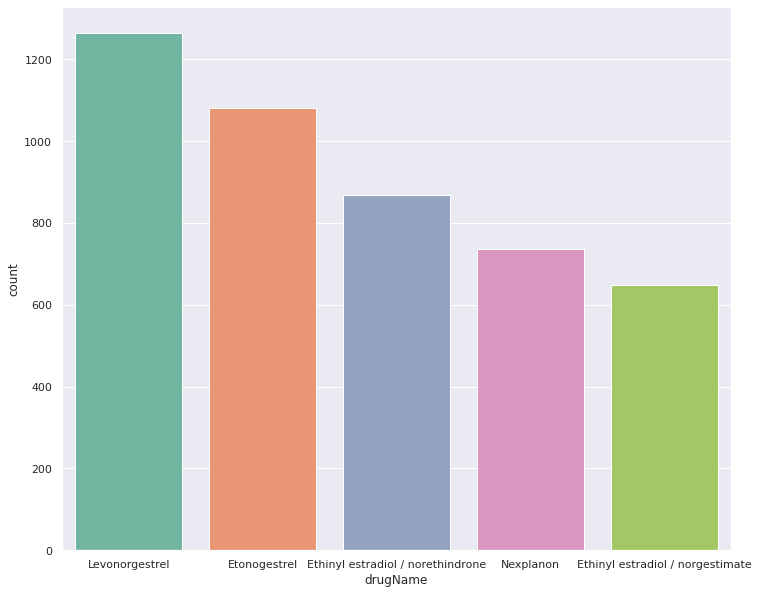

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="drugName", data=df, palette="Set2", order=df['drugName'].value_counts().index[0:5])

In [ ]:
drug_count=df['drugName'].value_counts().sort_values(ascending=False)
drug_count=pd.DataFrame(drug_count)
topdrug=drug_count[0:11]
topdrug

,drugName
Levonorgestrel,1265
Etonogestrel,1081
Ethinyl estradiol / norethindrone,869
Nexplanon,736
Ethinyl estradiol / norgestimate,649
Ethinyl estradiol / levonorgestrel,591
Phentermine,539
Sertraline,506
Escitalopram,452
Mirena,431


Selanjutnya, banyak isi dari baris data yang kotor berisi angka - angka dan simbol yang tidak diperlukan dan justru mengganggu pada saat proses preprocessing data. maka langka selanjutnya adalah membersihkan data tersebut dari dataset dengan cara menghilangkan simbol dan angka yang tidak diperlukan dengan cara ``df['metadata'] = df['metadata'].str.replace('\d+', '')``

In [ ]:
#cleaning number
df['metadata'] = df['metadata'].str.replace('\d+', '')
df.head(5)

,drugName,Prescribed_for,metadata
0,Mirtazapine,Depression,"Depression ""I&#;ve tried a few antidepressants..."
1,Mesalamine,"Crohn's Disease, Maintenance","Crohn's Disease, Maintenance ""My son has Crohn..."
2,Bactrim,Urinary Tract Infection,"Urinary Tract Infection ""Quick reduction of sy..."
3,Contrave,Weight Loss,"Weight Loss ""Contrave combines drugs that were..."
4,Cyclafem 1 / 35,Birth Control,"Birth Control ""I have been on this birth contr..."


In [ ]:
print('Rata - rata jumlah frasa per baris adalah {0:.0f}.'.format(df.groupby('drugName')['metadata'].count().mean()))

Rata - rata jumlah frasa per baris adalah 20.


In [ ]:
print('Jumlah frasa dalam data: {}. Jumlah kalimat dalam data {}. '.format(df.shape[0], len(df.drugName.unique())))

Jumlah frasa dalam data: 53766. Jumlah kalimat dalam data 2637. 


In [ ]:
print('Rata - rata panjang kata dari frasa pada dataset {0:.0f}.'.format(np.mean(df['metadata'].apply(lambda x: len(x.split())))))

Rata - rata panjang kata dari frasa pada dataset 85.


In [ ]:
have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(df['metadata']):
    if any(char in emoji.UNICODE_EMOJI for char in 'metadata'):
           have_emoji_train_idx.append(idx)

In [ ]:
train_emoji_percentage = round(len(have_emoji_train_idx) / df.metadata.shape[0] * 100, 2)
print(f'Train data has {len(have_emoji_train_idx)} rows that used emoji, that means {train_emoji_percentage} percent of the total')

Train data has 0 rows that used emoji, that means 0.0 percent of the total


In [ ]:
repeated_rows_train = []

for idx, review in enumerate(df['metadata']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)

        
print(f'Total {len(repeated_rows_train)} rows')

Total 5139 rows


In [ ]:
test1 = "UUUURRGGGEENNTTT"
print(re.sub(r'(\w)\1+', r'\1', test1))

test2 = "good product quality good value for money "
print(re.sub(r'(\w)\1+', r'\1', test2))

URGENT
god product quality god value for money 


In [ ]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [ ]:
df.loc[repeated_rows_train, 'metadata'] = df.loc[repeated_rows_train, 'metadata'].apply(delete_repeated_char)

In [ ]:
def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [ ]:
df['metadata'] = df['metadata'].apply(review_cleaning)

In [ ]:
before = pd.read_csv('/tmp/Drug_Data.csv')

print('Before: ', before.loc[1, 'Drug_Review'])
print('After: ', df.loc[1, 'metadata'])
print('')
print('')
print('Before: ', before.loc[50, 'Drug_Review'])
print('After: ', df.loc[50, 'metadata'])
print('')
print('')
print('Before: ', before.loc[100, 'Drug_Review'])
print('After: ', df.loc[100, 'metadata'])
print('')
print('')
print('Before: ', before.loc[1000, 'Drug_Review'])
print('After: ', df.loc[1000, 'metadata'])

Before:  "My son has Crohn&#039;s disease and has done very well on the Asacol.  He has no complaints and shows no side effects.  He has taken as many as nine tablets per day at one time.  I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically."
After:  crohn s disease maintenance my son has crohn s disease and has done very well on the asacol he has no complaints and shows no side effects he has taken as many as nine tablets per day at one time i ve been very happy with the results reducing his bouts of diarrhea drastically


Before:  "I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most 

In [ ]:
df.head()

,drugName,Prescribed_for,metadata
0,Mirtazapine,Depression,depression i ve tried a few antidepressants ov...
1,Mesalamine,"Crohn's Disease, Maintenance",crohn s disease maintenance my son has crohn s...
2,Bactrim,Urinary Tract Infection,urinary tract infection quick reduction of sym...
3,Contrave,Weight Loss,weight loss contrave combines drugs that were ...
4,Cyclafem 1 / 35,Birth Control,birth control i have been on this birth contro...


# Model Selection

## CountVectorizer

Untuk menggunakan data tekstual untuk pemodelan prediktif, teks harus diurai untuk menghapus kata-kata tertentu - proses ini disebut tokenisasi . Kata-kata ini kemudian perlu dienkode sebagai bilangan bulat, atau nilai floating-point, untuk digunakan sebagai masukan dalam algoritme pembelajaran mesin. Proses ini disebut ekstraksi fitur (atau vektorisasi). CountVectorizer digunakan untuk mengonversi kumpulan dokumen teks menjadi vektor jumlah istilah / token. Ini juga memungkinkan pra-pemrosesan data teks sebelum menghasilkan representasi vektor. CountVectorizer dikenal sangat handal dalam memproses tokenisasi pada teks.

CountVectorizer memiliki keunikan dalam mempresentasikan teks ke token dengan value hanya rentang (0,1) dan bisa sangat berguna untuk memproses data dengan alokasi waktu yang sangat cepat, akan tetapi memiliki kelemahan yang sangat besar yaitu bisa mempresentasikan kata yang berbeda tetapi dengan nilai yang serupa. Berikut adalah kelemahan yang dimiliki oleh CountVectorizer:

- Ketidakmampuannya dalam mengidentifikasi kata-kata yang lebih penting dan - kurang penting untuk dianalisis.
- hanya mempertimbangkan kata-kata yang berlimpah di corpus sebagai kata yang paling signifikan secara statistik.
- tidak mengidentifikasi hubungan antar kata seperti kesamaan linguistik antar kata.

Untuk penggunaan CountVectorizer cukup dengan memanggil kode from sklearn.feature_extraction.text import CountVectorizer dan secara default parameter yang diberikan sudah memberikan hasil yang optimal tanpa perlu setting lebih dalam lagi. pada dataset ini parameter yang digunakan hanya stop_words="english", tokenizer = word_tokenize sudah bisa memberikan hasil rekomendasi sistem yang bisa dibilang cukup baik.

In [ ]:
bow = CountVectorizer(stop_words="english", tokenizer = word_tokenize)
model = bow.fit_transform(df['metadata'])

## TfidfVectorizer

Jika pada CountVectorizer tokenisasi hanya memberikan nilai (0,1) pada setiap kata maka untuk Tfidf value yang diberikan memiliki rentang (0,2) yang mana sesuai dengan perhitungannya setiap kata memiliki representasi tersendiri dan tidak akan memiliki value yang sama seperti dengan CountVectorizer ini adalah salah satu kelebihan yang dimiliki oleh tfidf.

Untuk pemilihan value tinggi atau tidaknya tfidf memiliki cara dengan didasarkan pada logika bahwa kata-kata yang terlalu banyak dalam korpus dan kata-kata yang terlalu jarang keduanya tidak penting secara statistik untuk menemukan pola. Faktor logaritma dalam tfidf secara matematis menghukum kata-kata yang terlalu banyak atau terlalu jarang dalam korpus dengan memberikan nilai tfidf yang rendah.

Nilai tfidf yang lebih tinggi menandakan pentingnya kata-kata yang lebih tinggi dalam korpus sementara nilai yang lebih rendah mewakili kepentingan yang lebih rendah. Dalam contoh gambar di atas kata “AI” hadir dalam kedua kalimat tersebut sedangkan kata “natural” dan “computer” masing-masing hanya ada dalam satu kalimat. Oleh karena itu nilai tfidf “AI” lebih rendah dari dua lainnya. Sedangkan untuk kata “Natural” ada lebih banyak kata di Text1 sehingga kepentingannya lebih rendah daripada “Computer” karena jumlah kata di Text2 lebih sedikit.


Meskipun TFIDF dapat memberikan pemahaman yang baik tentang pentingnya kata-kata tetapi seperti halnya Hitung Vektor, kelemahannya adalah:

- Gagal memberikan informasi linguistik tentang kata-kata seperti arti sebenarnya dari kata-kata itu, kesamaan dengan kata-kata lain, dll.

In [ ]:
bow_tfidf = TfidfVectorizer(stop_words="english", tokenizer = word_tokenize)
model_tfidf = bow_tfidf.fit_transform(df['metadata'])

## Recommend

## Recommend CountVectorizer

In [ ]:
index = 0

dist = cosine_distances(code, model)
content = df.loc[index, "metadata"]
code = bow.transform([content])
rec_index = dist.argsort()[0, 1:10]
print(content)

depression i ve tried a few antidepressants over the years citalopram fluoxetine amitriptyline but none of those helped with my depression insomnia amp anxiety my doctor suggested and changed me onto mg mirtazapine and this medicine has saved my life thankfully i have had no side effects especially the most common weight gain i ve actually lost alot of weight i still have suicidal thoughts but mirtazapine has saved me


In [ ]:
df.loc[rec_index]

,drugName,Prescribed_for,metadata
203,Bupropion,Depression,depression saved my life
49308,Mirtazapine,Depression,depression have been on mirtazapine for nearly...
7176,Trazodone,Depression,depression i have suffered with anxiety and in...
43375,Fluoxetine,Panic Disorde,panic disorde i have been on fluoxetine for ma...
51440,Mirtazapine,Insomnia,insomnia i suffered a neurotoxic reaction to a...
24334,Mirtazapine,Depression,depression i have been on mirtazapine for abou...
31915,Mirtazapine,Anxiety,anxiety mirtazapine its amazing medicine my an...
48880,Prozac,Depression,depression prozac saved me
3484,Mirtazapine,Depression,depression i ve tried many antidepressants bef...


## Recommend TfidfVectorizer

In [ ]:
index = 0

dist_tfidf = cosine_distances(code, model_tfidf)
content = df.loc[index, "metadata"]
code = bow_tfidf.transform([content])
rec_index = dist.argsort()[0, 1:10]
print(content)

depression i ve tried a few antidepressants over the years citalopram fluoxetine amitriptyline but none of those helped with my depression insomnia amp anxiety my doctor suggested and changed me onto mg mirtazapine and this medicine has saved my life thankfully i have had no side effects especially the most common weight gain i ve actually lost alot of weight i still have suicidal thoughts but mirtazapine has saved me


In [ ]:
df.loc[rec_index]

,drugName,Prescribed_for,metadata
49308,Mirtazapine,Depression,depression have been on mirtazapine for nearly...
17136,Mirtazapine,Depression,depression mirtazapine made me so very tired h...
31915,Mirtazapine,Anxiety,anxiety mirtazapine its amazing medicine my an...
203,Bupropion,Depression,depression saved my life
24334,Mirtazapine,Depression,depression i have been on mirtazapine for abou...
43375,Fluoxetine,Panic Disorde,panic disorde i have been on fluoxetine for ma...
29380,Fluoxetine,Depression,depression first weeks on the medicine and i f...
51440,Mirtazapine,Insomnia,insomnia i suffered a neurotoxic reaction to a...
12629,Mirtazapine,Depression,depression i was prescribed mirtazapine after ...


## Evaluate

Metrik yang dipilih adalah cosine distance, cosine similarity dan precision dengan menggunakan bantuan library sklearn. Cosine distance  hanya ditentukan untuk nilai positif nilai dengan rentang terdekat dari 0 adalah yang termirip dengan konten utama dan akan menjadi top-N pada sistem rekomendasi. pada sistem rekomendasi dengan rumus perhitungannya adalah:
![](https://i2.wp.com/hendroprasetyo.com/wp-content/uploads/2020/04/image-9.png?resize=123%2C67&ssl=1)

Untuk cosine simiarity penjelasannya adalah mengukur kesamaan antara dua vektor dan menentukan apakah kedua vektor tersebut menunjuk ke arah yang sama. Ia menghitung sudut cosinus antara dua vektor. Semakin kecil sudut cosinus, semakin besar nilai cosine similarity. Simpelnya adalah semakin besar nilainya ke 1 dari penentuan konten yang dipilih maka akan menjadi top-N pada sistem rekomendasi. Rumus dari cosine similarity adalah:
![](https://dicoding-web-img.sgp1.cdn.digitaloceanspaces.com/original/academy/dos:784efd3d2ba47d47153b050526150ba920210910171725.jpeg)

Precision pada sistem rekomendasi diambil dari top hasil yang relevan kemudian dibagi dengan jumlah item yang direkomendasikan.

![](https://dicoding-web-img.sgp1.cdn.digitaloceanspaces.com/original/academy/dos:819311f78d87da1e0fd8660171fa58e620211012160253.png)

di Python dapat menghitung kedua metrik ini dengan cepat dengan library sklearn dengan kode ``from sklearn.metrics.pairwise import cosine_distances, cosine_similarity``. Pada dataset rekomendasi obat - obatan metrik yang diperoleh dari rekomendasi index ke-0 dipilih top-3 rekomendasi dan akan dilihat kedekatan rekomendasi dari konten dengan cara memilih index top-3 lalu transform ke numpy array, setelah itu dimasukkan ke perhutngan cosine distances dan similarity.

## Evaluate CountVectorizer 

In [ ]:
content = df.loc[0, "metadata"]
content1 = df.loc[203, "metadata"]
content2 = df.loc[49308	, "metadata"]
content3 = df.loc[7176, "metadata"]
userChoice = bow.transform([content])
rec1 = bow.transform([content1])
rec2 = bow.transform([content2])
rec3 = bow.transform([content3])

In [ ]:
dist1 = cosine_distances(userChoice, rec1)
dist2 = cosine_distances(userChoice, rec2)
dist3 = cosine_distances(userChoice, rec3)

print("Cosine distance terdekat yang menjadi rekomendasi dari konten adalah : ", dist1)
print("Cosine distance terdekat yang menjadi rekomendasi dari konten adalah : ", dist2)
print("Cosine distance terdekat yang menjadi rekomendasi dari konten adalah : ", dist3)

Cosine distance terdekat yang menjadi rekomendasi dari konten adalah :  [[0.57437173]]
Cosine distance terdekat yang menjadi rekomendasi dari konten adalah :  [[0.63253904]]
Cosine distance terdekat yang menjadi rekomendasi dari konten adalah :  [[0.64435662]]


In [ ]:
dist1 = cosine_similarity(userChoice, rec1)
dist2 = cosine_similarity(userChoice, rec2)
dist3 = cosine_similarity(userChoice, rec3)

print("Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah : ", dist1)
print("Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah : ", dist2)
print("Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah : ", dist3)

Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah :  [[0.36746096]]
Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah :  [[0.31118796]]
Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah :  [[0.34050261]]


## Evaluate TfidfVectorizer 

In [ ]:
content = df.loc[0, "metadata"]
row1 = df.loc[49308, "metadata"]
row2 = df.loc[17136	, "metadata"]
row3 = df.loc[31915, "metadata"]
userChoice = bow_tfidf.transform([content])
rec1 = bow.transform([row1])
rec2 = bow.transform([row2])
rec3 = bow.transform([row3])

In [ ]:
dist1 = cosine_distances(userChoice, rec1)
dist2 = cosine_distances(userChoice, rec2)
dist3 = cosine_distances(userChoice, rec3)

print("Cosine distance terdekat yang menjadi rekomendasi dari konten adalah : ", dist1)
print("Cosine distance terdekat yang menjadi rekomendasi dari konten adalah : ", dist2)
print("Cosine distance terdekat yang menjadi rekomendasi dari konten adalah : ", dist3)

Cosine distance terdekat yang menjadi rekomendasi dari konten adalah :  [[0.65108246]]
Cosine distance terdekat yang menjadi rekomendasi dari konten adalah :  [[0.70736372]]
Cosine distance terdekat yang menjadi rekomendasi dari konten adalah :  [[0.69698051]]


In [ ]:
dist1 = cosine_similarity(userChoice, rec1)
dist2 = cosine_similarity(userChoice, rec2)
dist3 = cosine_similarity(userChoice, rec3)

print("Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah : ", dist1)
print("Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah : ", dist2)
print("Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah : ", dist3)

Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah :  [[0.34891754]]
Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah :  [[0.29263628]]
Kemiripan kata antar baris yang menjadi rekomendasi dari konten adalah :  [[0.30301949]]


## Evaluate Precision 

In [ ]:
df.loc[rec_index]

,drugName,Prescribed_for,metadata
49308,Mirtazapine,Depression,depression have been on mirtazapine for nearly...
17136,Mirtazapine,Depression,depression mirtazapine made me so very tired h...
31915,Mirtazapine,Anxiety,anxiety mirtazapine its amazing medicine my an...
203,Bupropion,Depression,depression saved my life
24334,Mirtazapine,Depression,depression i have been on mirtazapine for abou...
43375,Fluoxetine,Panic Disorde,panic disorde i have been on fluoxetine for ma...
29380,Fluoxetine,Depression,depression first weeks on the medicine and i f...
51440,Mirtazapine,Insomnia,insomnia i suffered a neurotoxic reaction to a...
12629,Mirtazapine,Depression,depression i was prescribed mirtazapine after ...


In [8]:
#Precision = of recommendation that are relevant/of item we recommend
#6 diambil dari rekomendasi gejala yang didapat
precision = (6/9) * 100
print("Hasil precision dari rekomendasi sistem adalah ", precision,'%')

Hasil precision dari rekomendasi sistem adalah  66.66666666666666 %


In [9]:
#Jika diambil top-5
precision = (4/5) * 100
print("Hasil precision dari rekomendasi sistem adalah ", precision,'%')

Hasil precision dari rekomendasi sistem adalah  80.0 %
